## Model Evaluation

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import json

### Step 1: Classification into LCA/RCA using YOLOV8X-cls

#### Summary
The base line literature achieved 100% accuracy for this task. 

My attempt acheived 75% for LCA and only 26% for RCA.


To prevent my bad classifier from impacting the second step in the pipeline, I trained the segmentation models on data which I split manually into LCA/RCA, since the baseline would have that data correctly split from their classifier anyway

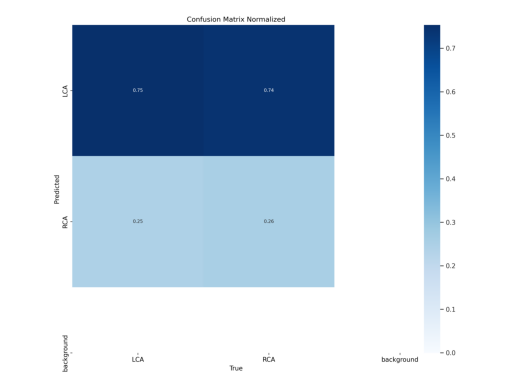

In [62]:
conf_matrix = plt.imread('models/cls/firsttrain/confusion_matrix_normalized.png')
plt.imshow(conf_matrix)
plt.axis('off')
plt.show()

### Step 2: Segmentation using YOLOv8x-seg. One model for LCA images and another for RCA images

#### Percentage diff between my attempt and baseline lit results

In [63]:
segL = pd.read_csv('models/segL/second/CLI_SUMMARY.txt', skiprows=2, index_col='Class')
segLbase = pd.read_csv('models/segL/baselineres.txt', index_col='Class')
segR = pd.read_csv('models/segR/second/CLI_SUMMARY.txt', skiprows=2, index_col='Class')
segRbase = pd.read_csv('models/segR/baselineres.txt', index_col='Class')

with open("val.json", encoding="utf-8") as file:
    gt = json.load(file)
cats={}
for i in gt['categories']:
    cats[str(i['id'])]=i['name']

segL, segR = segL.copy(), segR.copy()
new_indexL = [segL.index[0]] + [cats[idx] for idx in segL.index[1:]]
new_indexR = [segR.index[0]] +[cats[idx] for idx in segR.index[1:]]
segL.index, segR.index = new_indexL, new_indexR

In [64]:
def calc_dice(df):
    inter = df['Mask_P'] * df['Mask_R']
    union = df['Mask_P'] + df['Mask_R']
    return 2*inter/union

segL = segL[['Images', 'Instances', 'Mask_P', 'Mask_R']].copy()
segR = segR[['Images', 'Instances', 'Mask_P', 'Mask_R']].copy()

segL['Mask_Dice'] = calc_dice(segL).round(2)
segR['Mask_Dice'] = calc_dice(segR).round(2)

In [65]:
def calc_percent_diff(df1, df2):
    return 100*(df2-df1)/df1

diffR = pd.DataFrame({'Prec':calc_percent_diff(segRbase['Prec'], segR['Mask_P']),
                      'Rec':calc_percent_diff(segRbase['Rec'], segR['Mask_R']),
                      'Dice':calc_percent_diff(segRbase['Dice'], segR['Mask_Dice'])}).round(2)
diffR

,Prec,Rec,Dice
all,4.17,-17.30,-6.56
1,0.98,-2.62,-1.20
2,-5.38,-28.80,-17.50
3,17.18,-0.26,8.22
4,-5.27,-5.57,-5.56
16,-12.97,-7.75,-9.72
16a,-29.03,-45.00,-36.11
16b,-42.67,-42.59,-43.14
16c,199.23,-30.56,4.76


In [66]:
segLbase_aligned = segLbase.reindex(segL.index)

diffL = pd.DataFrame({
    'Prec': calc_percent_diff(segLbase_aligned['Prec'], segL['Mask_P']),
    'Rec':  calc_percent_diff(segLbase_aligned['Rec'],  segL['Mask_R']),
    'Dice': calc_percent_diff(segLbase_aligned['Dice'], segL['Mask_Dice']),
}).round(2)
diffL

,Prec,Rec,Dice
all,37.86,-16.15,8.70
5,-0.11,1.18,1.23
6,-10.49,-4.16,-7.59
7,8.75,-18.46,-5.71
8,55.45,22.46,36.67
9,140.00,0.00,54.29
9a,29.71,-13.04,7.69
10,11.86,-42.80,-25.93
10a,NaN,NaN,NaN
11,-9.88,-7.50,-8.24
